# Предсказание погоды (умная метеостанция)

In [40]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00


In [41]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

## EDA

In [42]:
df = pd.read_csv('weather.csv')

In [43]:
df.head()

,timestamp,Temperature,Humidity,Pressure
0,20060101T0000,5.180245,91.458470,1004.3
1,20060101T0100,5.900245,90.427020,1004.3
2,20060101T0200,5.230245,93.421486,1005.0
3,20060101T0300,4.640245,94.113460,1005.6
4,20060101T0400,4.620246,91.608460,1006.0


In [44]:
df.describe()

,Temperature,Humidity,Pressure
count,166560.000000,166560.000000,166560.000000
mean,11.581896,76.567545,1017.446569
std,8.148316,16.805044,8.309122
min,-15.959755,10.013839,976.300000
25%,5.430245,66.578454,1012.800000
50%,11.280245,81.577192,1017.500000
75%,17.350245,89.756416,1022.500000
max,38.570248,100.072490,1045.800000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166560 entries, 0 to 166559
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    166560 non-null  object 
 1   Temperature  166560 non-null  float64
 2   Humidity     166560 non-null  float64
 3   Pressure     166560 non-null  float64
dtypes: float64(3), object(1)
memory usage: 5.1+ MB


Переводим в миллиметры ртутного столба

In [46]:
df['Pressure (mmHg)'] = (df['Pressure'] / 1.33322)
df.drop('Pressure', axis=1, inplace=True)

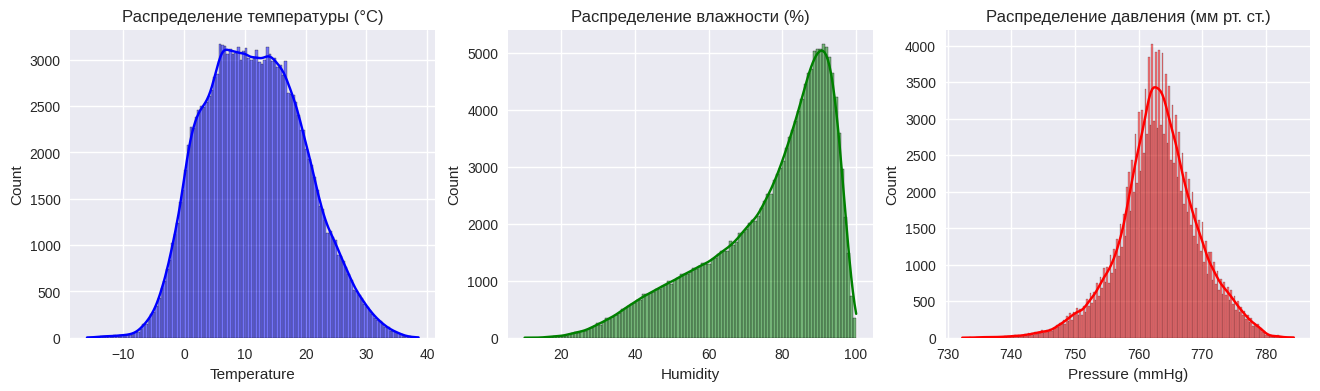

In [47]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.histplot(df['Temperature'], kde=True, color='blue')
plt.title('Распределение температуры (°C)')
plt.subplot(1,3,2)
sns.histplot(df['Humidity'], kde=True, color='green')
plt.title('Распределение влажности (%)')
plt.subplot(1,3,3)
sns.histplot(df['Pressure (mmHg)'], kde=True, color='red')
plt.title('Распределение давления (мм рт. ст.)')
plt.show()

In [48]:
df['Formatted Date'] = pd.to_datetime(df['timestamp'], format='%Y%m%dT%H%M')
df['Month'] = df['Formatted Date'].dt.month

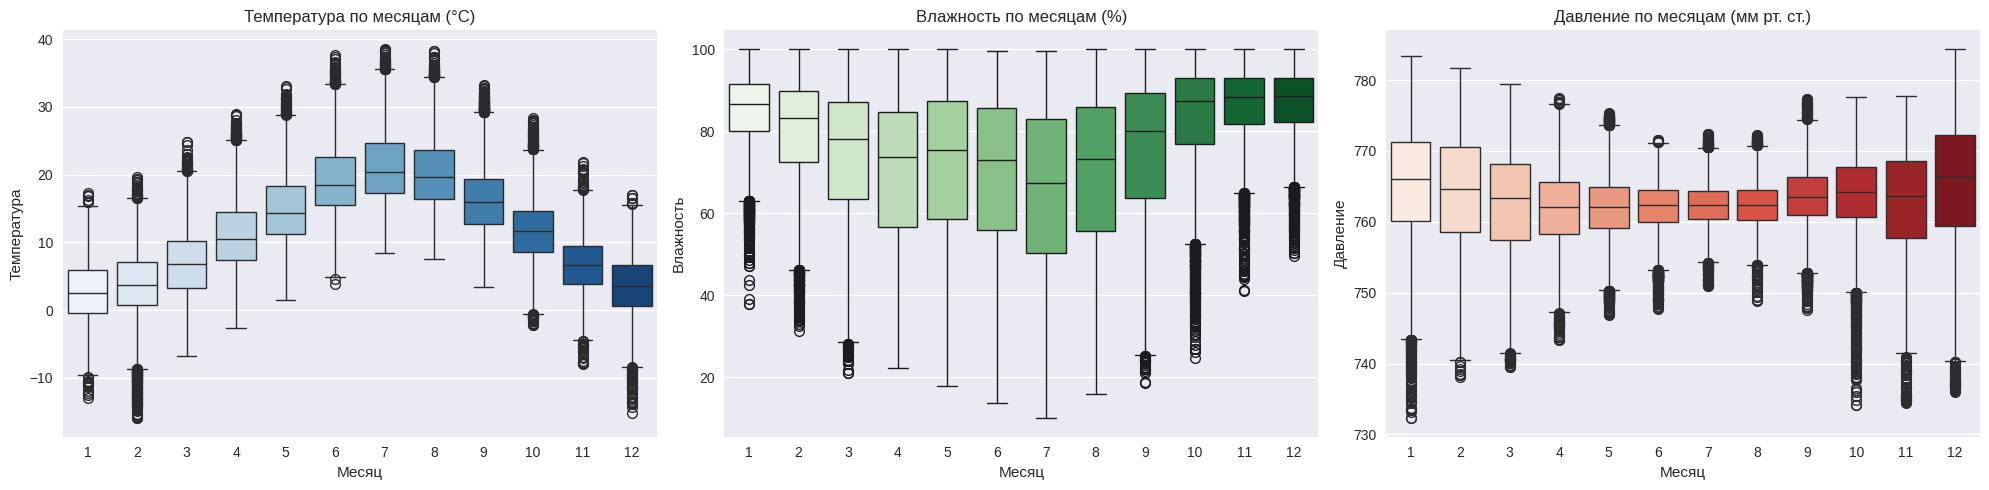

In [49]:
# Boxplot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(x='Month', y='Temperature', data=df, ax=axes[0], palette='Blues')
axes[0].set_title('Температура по месяцам (°C)')
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Температура')

sns.boxplot(x='Month', y='Humidity', data=df, ax=axes[1], palette='Greens')
axes[1].set_title('Влажность по месяцам (%)')
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Влажность')

sns.boxplot(x='Month', y='Pressure (mmHg)', data=df, ax=axes[2], palette='Reds')
axes[2].set_title('Давление по месяцам (мм рт. ст.)')
axes[2].set_xlabel('Месяц')
axes[2].set_ylabel('Давление')

plt.tight_layout()
plt.show()

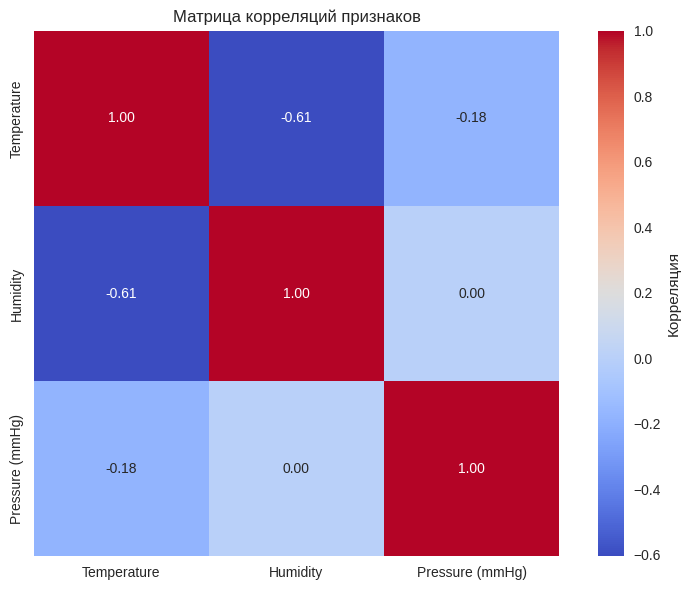

In [50]:
numeric_cols = ['Temperature', 'Humidity', 'Pressure (mmHg)']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'label': 'Корреляция'})
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

В целом, датасет похож по структуре на Санкт-Петербург

## Feature Engineering

Округляем значения, чтобы привести данные к формату метеостанции (точность до 1 знака после запятой)

In [51]:
df['Pressure (mmHg)'] = (df['Pressure (mmHg)']).round(1)
df['Temperature'] = df['Temperature'].round(1)
df['Humidity'] = df['Humidity'].round(1)

In [52]:
df = df.drop(columns=['timestamp'])
df['Hour'] = df['Formatted Date'].dt.hour
df['DayOfMonth'] = df['Formatted Date'].dt.day
df['Target_Temperature'] = df['Temperature'].shift(-6)
df['Target_Rain'] = ((df['Humidity'].shift(-6) > 80) & (df['Pressure (mmHg)'].shift(-6) < 755)).astype(int)
df.drop('Formatted Date', axis=1, inplace=True)
df = df.dropna().reset_index(drop=True)

In [53]:
df.head()

,Temperature,Humidity,Pressure (mmHg),Month,Hour,DayOfMonth,Target_Temperature,Target_Rain
0,5.2,91.5,753.3,1,0,1,4.2,0
1,5.9,90.4,753.3,1,1,1,4.2,0
2,5.2,93.4,753.8,1,2,1,4.1,0
3,4.6,94.1,754.3,1,3,1,4.0,0
4,4.6,91.6,754.6,1,4,1,5.0,0


Датасет не содержит явной метки наличия дождя, поэтому целевой признак Target_Rain формируется на основе приближённой эвристики:

- влажность выше 80%

- давление ниже 755 мм рт. ст.

Такая комбинация характерна для влажного циклонического фронта и может служить косвенным индикатором вероятности осадков.
Метод приближённый, но допустим в условиях отсутствия реальных метеонаблюдений

## Обучение

In [54]:
features = ['Temperature', 'Humidity', 'Pressure (mmHg)', 'Month', 'Hour', 'DayOfMonth']

X = df[features]
y = df[['Target_Temperature', 'Target_Rain']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
models = {
    'RandomForest': (MultiOutputRegressor(RandomForestRegressor(random_state=42)),
                     {'estimator__n_estimators': [50, 100], 'estimator__max_depth': [5, 10]}),
    'ExtraTrees': (MultiOutputRegressor(ExtraTreesRegressor(random_state=42)),
                   {'estimator__n_estimators': [50, 100]}),
    'XGB': (MultiOutputRegressor(XGBRegressor(tree_method='hist', random_state=42)),
            {'estimator__n_estimators': [50, 100], 'estimator__max_depth': [3, 5]}),
    'CatBoost': (MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=42)),
        {'estimator__depth': [4, 6], 'estimator__learning_rate': [0.05, 0.1]}
    ),
    'LGBM': (MultiOutputRegressor(LGBMRegressor(random_state=42)),
             {'estimator__n_estimators': [50, 100], 'estimator__max_depth': [5, 10]}),
    'Ridge': (MultiOutputRegressor(Ridge()), {}),
    'DecisionTree': (MultiOutputRegressor(DecisionTreeRegressor(random_state=42)),
                     {'estimator__max_depth': [5, 10]}),
    'KNN': (MultiOutputRegressor(KNeighborsRegressor()),
            {'estimator__n_neighbors': [3, 5, 7]})
}

results = {}
best_models = {}

Обоснование выбора метрик

**Температура (Target_Temperature)** → оценивалась с помощью **RMSE (Root Mean Squared Error)**, так как:
- RMSE даёт простую и понятную интерпретацию "средняя ошибка в градусах"
- штрафует крупные ошибки сильнее, что важно для прогнозирования температуры

**Дождь (Target_Rain)** → оценивался с помощью **F1-score**, так как:
- классы сильно несбалансированы (больше дней без дождя)
- accuracy дал бы ложное впечатление качества
- F1 лучше отражает баланс между precision и recall

In [56]:
for name, (model, params) in models.items():
    if params:
        grid = GridSearchCV(model, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)
        best_model = model

    preds = best_model.predict(X_test_scaled)
    rmse = sqrt(mean_squared_error(y_test['Target_Temperature'], preds[:, 0]))
    rain_pred = np.where(preds[:, 1] >= 0.5, 1, 0)
    f1 = f1_score(y_test['Target_Rain'], rain_pred)
    results[name] = {'RMSE (t°C)': rmse, 'F1 (дождь)': f1}
    best_models[name] = best_model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 133243, number of used features: 6
[LightGBM] [Info] Start training from score 11.580124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 133243, number of used features: 6
[LightGBM] [Info] Start training from score 0.061009


In [57]:
print("\n=== Результаты моделей ===")
for model_name, metrics in results.items():
    print(f"{model_name:12s} | RMSE: {metrics['RMSE (t°C)']:.3f} | F1: {metrics['F1 (дождь)']:.3f}")


=== Результаты моделей ===
RandomForest | RMSE: 2.077 | F1: 0.763
ExtraTrees   | RMSE: 1.773 | F1: 0.808
XGB          | RMSE: 1.907 | F1: 0.767
CatBoost     | RMSE: 1.830 | F1: 0.784
LGBM         | RMSE: 1.930 | F1: 0.764
Ridge        | RMSE: 3.474 | F1: 0.113
DecisionTree | RMSE: 2.198 | F1: 0.735
KNN          | RMSE: 1.638 | F1: 0.841


Лучшей моделью оказался KNN:

RMSE = 1.638, F1 = 0.841

In [58]:
best_model_name = max(results.items(), key=lambda x: (1 - x[1]['RMSE (t°C)']) + x[1]['F1 (дождь)'])[0]
best_model = best_models[best_model_name]
best_model

MultiOutputRegressor(estimator=KNeighborsRegressor(n_neighbors=3))

In [59]:
best_model.fit(X_train_scaled, y_train)

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']